In [1]:
from utils import datasets, kl_cpd, models, metrics
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import torch

import numpy as np
import time
from sklearn import manifold
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
experiments_name = 'explosion'
train_dataset, test_dataset = datasets.CPDDatasets(experiments_name=experiments_name).get_dataset_()

Equal sampling is impossible, do random sampling.


In [19]:
args = {}
args['wnd_dim'] = 4
args['RNN_hid_dim'] = 16
args['batch_size'] = 4
args['lr'] = 1e-4
args['weight_decay'] = 0.
args['grad_clip'] = 10
args['CRITIC_ITERS'] = 5
args['weight_clip'] = .1
args['lambda_ae'] = 0.1 #0.001
args['lambda_real'] = 10 #0.1
args['num_layers'] = 1
#args['data_dim'] = 12288
args['data_dim'] = 2400
#args['data_dim'] = 
args['emb_dim'] = 100

args['window_1'] = 4
args['window_2'] = 4

args['sqdist'] = 50

In [20]:
seed = 112
models.fix_seeds(seed)
experiments_name = ('explosion')
    
netG = models.NetG(args)
netD = models.NetD(args)
netE = models.NetE(args)

kl_cpd_model = models.KLCPDVideo(netG, netD, args, extractor=netE, train_dataset=train_dataset, test_dataset=test_dataset)

In [21]:
kl_cpd_model

KLCPDVideo(
  (netG): NetG(
    (relu): ReLU()
    (fc): Linear(in_features=2400, out_features=100, bias=True)
    (rnn_enc_layer): GRU(100, 16, batch_first=True)
    (rnn_dec_layer): GRU(100, 16, batch_first=True)
    (fc_layer): Linear(in_features=16, out_features=2400, bias=True)
  )
  (netD): NetD(
    (fc1): Linear(in_features=2400, out_features=100, bias=True)
    (rnn_enc_layer): GRU(100, 16, batch_first=True)
    (rnn_dec_layer): GRU(16, 100, batch_first=True)
    (fc2): Linear(in_features=100, out_features=2400, bias=True)
    (relu): ReLU()
  )
  (extractor): NetE(
    (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(2, 2), dilation=(2, 2))
    (conv2): Conv2d(12, 6, kernel_size=(3, 3), stride=(2, 2), dilation=(2, 2))
    (maxpool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
)

In [22]:
logger = TensorBoardLogger(save_dir='logs/explosion', name='kl_cpd')
early_stop_callback = EarlyStopping(monitor="val_mmd2_real_D", stopping_threshold=1e-5, 
                                    verbose=True, mode="min", patience=5)



for param in kl_cpd_model.extractor.parameters():
    param.requires_grad = False

trainer = pl.Trainer(
    max_epochs=100,
    gpus='1',
    benchmark=True,
    check_val_every_n_epoch=1,
    gradient_clip_val=args['grad_clip'],
    logger=logger,
    callbacks=early_stop_callback
)

trainer.fit(kl_cpd_model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type | Params
-----------------------------------
0 | netG      | NetG | 292 K 
1 | netD      | NetD | 523 K 
2 | extractor | NetE | 1.6 K 
-----------------------------------
815 K     Trainable params
1.6 K     Non-trainable params
817 K     Total params
3.269     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_mmd2_real_D improved. New best score: 0.000


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_mmd2_real_D improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Validation: 0it [00:00, ?it/s]

Stopping threshold reached: val_mmd2_real_D = 8.133070878102444e-06 < 1e-05. Signaling Trainer to stop.


In [23]:
threshold_number = 25
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

In [24]:
_, delay_list, fp_delay_list = metrics.evaluation_pipeline(kl_cpd_model, 
                                                           kl_cpd_model.val_dataloader(),  
                                                           threshold_list, 
                                                           device='cuda', 
                                                           model_type='klcpd',
                                                           verbose=False)    



100%|██████████| 27/27 [44:03<00:00, 97.92s/it] 


In [25]:
path_to_saves = 'saves/'
metrics.write_metrics_to_file(path_to_saves + 'result_metrics_conv2d_win4_new.txt', _, '')

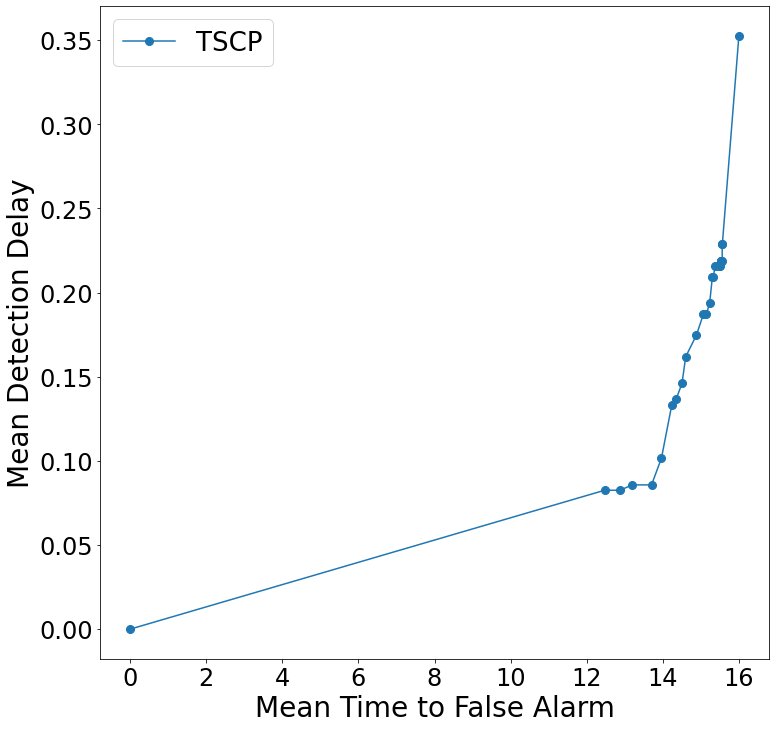

In [26]:
plt.figure(figsize=(12, 12))
plt.plot(fp_delay_list.values(), delay_list.values(), '-o', markersize=8, label='TSCP')
plt.xlabel('Mean Time to False Alarm', fontsize=28)
plt.ylabel('Mean Detection Delay', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(loc='upper left', fontsize=26);        
plt.savefig(path_to_saves + '_conv2d_win4_new' + 'curve.png')

In [27]:
with open(path_to_saves + 'result_metrics_conv2d_win4_new.txt') as f:
    lines = f.readlines()
for l in lines:
    print(l)

SEED: 

AUC: 1.270456018634749

Time to FA 11.0571, delay detection 0.0476 for best-F1 threshold: 0.9933

TN 123, FP 185, FN 0, TP 7 for best-F1 threshold: 0.9933

Max F1 0.0704: for best-F1 threshold 0.9933

COVER 0.7577: for best-F1 threshold 0.9933

Max COVER 0.9806299603174603: for threshold -0.001

----------------------------------------------------------------------

SEED: 

AUC: 1.4480222770142221

Time to FA 9.7048, delay detection 0.0381 for best-F1 threshold: 0.9933

TN 79, FP 229, FN 0, TP 7 for best-F1 threshold: 0.9933

Max F1 0.0576: for best-F1 threshold 0.9933

COVER 0.6941: for best-F1 threshold 0.9933

Max COVER 0.9806299603174603: for threshold -0.001

----------------------------------------------------------------------

SEED: 

AUC: 1.0357168330203343

Time to FA 15.5651, delay detection 0.2286 for best-F1 threshold: 0.9933

TN 290, FP 11, FN 6, TP 8 for best-F1 threshold: 0.9933

Max F1 0.4848: for best-F1 threshold 0.9933

COVER 0.9712: for best-F1 threshold 0.